In [91]:
import numpy as np
import scipy as sp
import cupy as cp

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from utils.criticality import dfa
from utils.kuramoto import KuramotoFast
from utils.pairwise import cplv
from utils.vis import plot_dfa_with_linfit

### Introduction
This is a tutorial for the Hierarchical Kuramoto usage. The model code is self-containing and dependencies are minimal, essentially numpy is the only mandatory dependency. However, because the model has a lot of interacting units, we recommend to use GPU for simulations which is supported natively, just install CuPy Python package ( https://cupy.dev/ ) and set use_cuda=True.

The model usage is pretty straightforward:
1. Initialize the model using the KuramotoFast class (or other model extension)
2. Run the model with model.simulate(...)
3. The model returns a complex timeseries of size N_nodes x N_ts where N_ts is simulation_time x sfreq + 1 (similar to narrow-band complex data after filtering)

In then next parts we will show it in practice.

In [92]:
np.random.seed(42)

In [121]:
import networkx  as nx
def get_uniform_connectome(n_nodes: int):
    sc = np.random.uniform(size=(n_nodes, n_nodes))
    sc = (sc + sc.T)/2

    sc /= sc.mean() 
    return sc

def generate_random_sbm_graph_mask(n_nodes=50):
    probs = [[0.35, 0.05, 0.02], [0.05, 0.45, 0.07], [0.02, 0.07, 0.55]]
    sizes = [20, 20, 10]

    g = nx.stochastic_block_model(sizes, probs, seed=0)
    W = nx.to_numpy_array(g, nodelist=sorted(g.nodes()), weight="weight", dtype=float)

    # W /= W.mean()
    return W.astype(bool)

# generate some random SC either uniform or powelaw-scaled
def generate_random_sc(type='uniform'):
    alpha_in = 1.5
    alpha_out = 2.5
    scale_in = 1.0  
    scale_out = 0.2

    sbm_mask = generate_random_sbm_graph_mask()

    if type == 'pl_scaled':
        w_inside = (np.random.pareto(alpha_in, size=sbm_mask.shape) + 1)*scale_in
        w_outside = (np.random.pareto(alpha_out, size=sbm_mask.shape) + 1)*scale_out
    elif type == 'uniform':
        w_inside = np.random.uniform(0.8, 1.0, size=sbm_mask.shape)
        w_outside = np.random.uniform(0.0, 0.3, size=sbm_mask.shape)

    w_aggregated = np.empty(sbm_mask.shape, dtype=float)
    w_aggregated[sbm_mask] = w_inside[sbm_mask]
    w_aggregated[~sbm_mask] = w_outside[~sbm_mask]

    i_lower = np.tril_indices(w_aggregated.shape[0], -1)
    w_aggregated[i_lower] = w_aggregated.T[i_lower]

    w_aggregated /= w_aggregated.mean()

    return w_aggregated

### Model description

We introduce a hierarchical extension of the Kuramoto model with multiple nodes comprising multiple locally coupled oscillators, analogously to the analysis of electrophysiological recordings, where each electrode or cortical parcel represents a large number of locally interacting neurons. The behavior of individual oscillators within a node is governed by three terms:

$\frac{\delta \phi_i^n}{\delta t} = Natural + Internal + External + Noise$

Where $Natural = w_i^n$ represents a frequency of the i-th oscillator in the n-th node and $\phi_i^n$ is the oscillator phase, 

$Internal=\frac{K_n}{N}\sum_{j=1}^{N}sin(\phi_j^n-\phi_i^n)$

Representing dynamics internal for each node, where $K_n$ is the local coupling parameter of the n-th node and N is the total number of oscillators within the node. In this context, the phase of each oscillator is shifted towards the average phase of oscillators within a node,

$External = \sum_{j=1}^{k} L^{n,j}*W^{n,j}*sin(\Phi^j-\phi_i^n)*R^j$

Representing interactions external to a node, where $L^{n,j}$ is the coupling coefficient between the n-th and j-th nodes (global control parameter), $W^{n,j}$ is the SC between the n-th and j-th nodes, $\Phi^j$ is the cyclic average of the phases of the j-th node defined as $\Phi^j = arg(\frac{1}{N}\sum_{q=1}^N e^{i\phi_q^j})$ and $R^j$ is the order (complex modulus) of the j-th node. In this context, the phase of each oscillator is compared to the average phase of other nodes and weighted by a target node order and edge strength while within-node oscillators are connected in all-to-all fashion with the weight equal to K.

### Model parameters

The model has several parameters and the most important are:

1. Number of oscillators

Number of Kuramoto oscillators per model node. We recommend using 500-1000 oscillators per node (see supplementary Figure 6 or correspodning notebook for details)

2. K

Coupling strength between oscillators within the same node. It controls the _internal_ part of the model dynamics.

3. Weight matrix

Coupling strength between an oscillator and an external node. It controls the _external_ part of the model dynamics. Could be a generated network with desired properties (e.g. small-world networks) or real structural connectome.

4. Node frequencies

Central frequencies for each node, the frequencies by default are drawn from the gaussian distribution with given scale. One can also set oscillator frequencies manually using the set_omegas method.

5. Frequency scale

Scale of the ocillator frequencies, we recommend using 1.0

In [ ]:
n_nodes = 50

sfreq = 200
sim_time = 360

central_frequency = 10
node_frequencies = n_nodes*[central_frequency]

n_oscillators = 500
frequency_scale = 1.0

connectome_uniform = generate_random_sc('uniform')

# DFA exponent is fit using windows from size 10 cycles of the central frequency to 25% of the whole data
dfa_win_lengths = np.geomspace(int(sfreq/central_frequency)*10, int(sim_time*sfreq)//4, 30)

### Running the model

After the model is initialized, one can run the simulation using _simulate_ method.

Important: for the visualization purpose, we do not aggregate oscillator timeseries to node timeseries and pass _aggregate=False_ . This is very memory consuming (because one needs to save an array of size N_nodes x N_oscillators x N_ts) and might take several tens of GB memory which is especially important if you use GPU  with limited vRAM. Do not use it for large-scale analysis.

In [ ]:
k = 6.0
k_list = [k]*n_nodes

L = 4

model = KuramotoFast(n_oscillators, sfreq, k_list=k_list, weight_matrix=connectome_uniform*L, noise_scale=1.0,
                     node_frequencies=node_frequencies, scale=frequency_scale, use_cuda=True)

data_sim_full = model.simulate(sim_time, aggregate=False)

# since node timeseries is an average of its oscillators, we can just compute mean across oscillators dimension.
# after this step, one can interpret such timeseries as any complex  narrow-band data and compute observables of interests
# such as amplitude (order), DFA exponent, phase synchronization or amplitude correlation
data_sim = data_sim_full.mean(axis=1) 

# data order is just complex modulus of average oscillator complex phase
data_order = np.abs(data_sim)

data_plv = np.abs(cplv(data_sim))
np.fill_diagonal(data_plv, np.nan)

data_cc = np.corrcoef(data_order)

fluct, slope, dfa_values, residuals = dfa(data_order, window_lengths=dfa_win_lengths)

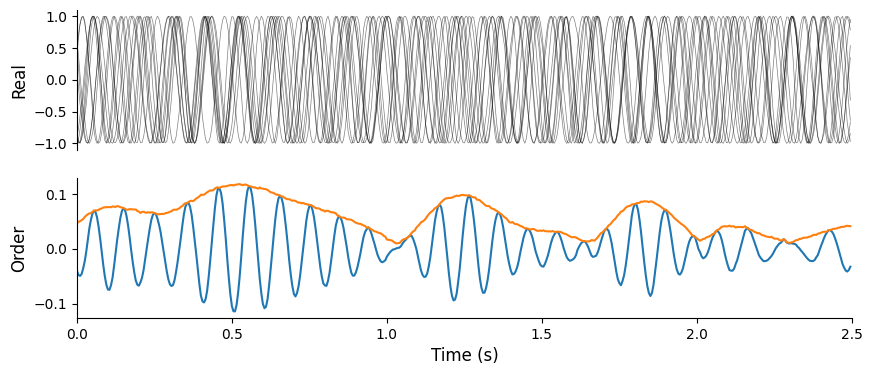

In [108]:
fig, axes = plt.subplots(figsize=(10,4), nrows=2)

t = np.arange(500)/sfreq

axes[0].plot(t, data_sim_full[0, ::50, :500].T.real, color='black', alpha=0.5, lw=0.5)
axes[1].plot(t, data_sim[0, :500].real)
axes[1].plot(t, data_order[0, :500])

axes[0].set_xticks([])
axes[0].set_ylabel('Real', fontsize=12)
axes[1].set_ylabel('Order', fontsize=12)
axes[1].set_xlabel('Time (s)', fontsize=12)

for ax in axes:
    ax.set_xlim([0, 500/sfreq])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].spines['bottom'].set_visible(False)

Lets visualize some of our DFA exponents as simple sanity check. We except to see ~ linear relataions between window size and fluctuation in the loglog scale.

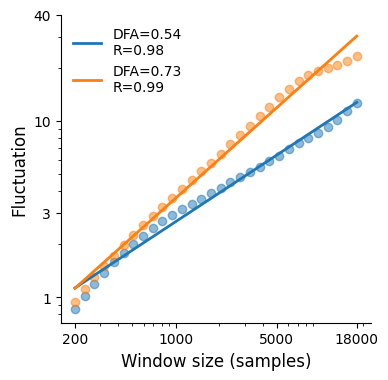

In [120]:
min_dfa_idx = dfa_values.argmin()
max_dfa_idx = dfa_values.argmax()

fig, ax = plt.subplots(figsize=(4, 4))

plot_dfa_with_linfit(dfa_win_lengths, fluct[min_dfa_idx], ax=ax)
plot_dfa_with_linfit(dfa_win_lengths, fluct[max_dfa_idx], ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')


ax.xaxis.set_minor_formatter(mticker.NullFormatter())
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())

ax.yaxis.set_minor_formatter(mticker.NullFormatter())
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

ax.set_xticks([200, 1000, 5000, 18000])
ax.set_yticks([1, 3, 10, 40])

ax.set_xlabel('Window size (samples)', fontsize=12)
ax.set_ylabel('Fluctuation', fontsize=12)

ax.legend(frameon=False, fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


Since we are interested also in transition between order and disorder, lets iterate through multiple local coupling strengths and plot average of model observables as function of it.
In order to save time, lets fix the global coupling strength.

In [9]:
k_values = np.linspace(0, 8, 40)

order_as_k = np.zeros((len(k_values), n_nodes))
dfa_as_k = np.zeros((len(k_values), n_nodes))
plv_as_k = np.zeros((len(k_values), n_nodes, n_nodes))
cc_as_k = np.zeros((len(k_values), n_nodes, n_nodes))

for k_idx, k in enumerate(k_values):
    model = KuramotoFast(n_oscillators, sfreq, k_list=[k]*n_nodes, weight_matrix=connectome_uniform*L, 
                     node_frequencies=node_frequencies, scale=frequency_scale, use_cuda=True)

    data_sim = model.simulate(sim_time)
    data_sim = data_sim[..., sfreq*20:]

    data_envelope = np.abs(data_sim)

    order_as_k[k_idx] = data_envelope.mean(axis=-1)
    dfa_as_k[k_idx] = dfa(data_envelope, window_lengths=dfa_win_lengths)[2]
    
    plv_as_k[k_idx] = np.abs(cplv(data_sim))
    cc_as_k[k_idx] = np.corrcoef(data_envelope)

The DFA exponent peaks during the phase transition on the nodal and inter-nodal level. Interestingly, the cross-correlation between node order also peaks during such transition and its peak is aligned with DFA exponent peak!

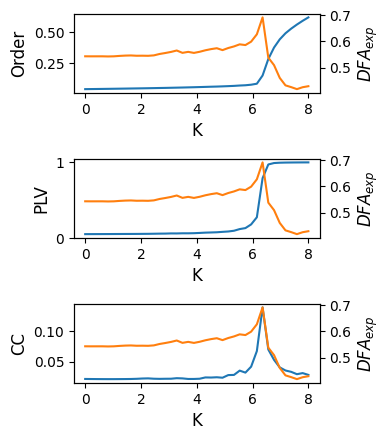

In [10]:
fig, axes = plt.subplots(figsize=(4,4.5), nrows=3)
axes_twins = [ax.twinx() for ax in axes]

observables_list = [order_as_k, plv_as_k.mean(axis=-1), cc_as_k.mean(axis=-1)]

for ax, ax_twin, observable_name, (observable_arr, observable_arr_twin) in zip(axes, axes_twins, ['Order', 'PLV', 'CC'],
                                                                               zip(observables_list, [dfa_as_k, dfa_as_k, dfa_as_k])):
    
    ax.plot(k_values, observable_arr.mean(axis=-1), color='C0')
    ax_twin.plot(k_values, observable_arr_twin.mean(axis=-1), color='C1')

    ax.set_xlabel('K', fontsize=12)
    ax.set_ylabel(observable_name, fontsize=12)
    ax_twin.set_ylabel(r'$DFA_{exp}$', fontsize=12)

fig.tight_layout()

When we check Structure-Function-Coupling (correlation between SC and model observables), we found two types of such  behaviour:

1. Peaks in the subcritical side of the extended regime of critical-like dynamics and drops at criticality (PLV and Order, although SFC for order becomes high in the supercritical region)

2. Peaks precisely at criticality (CC and DFA).

In [11]:
triu_indices = np.triu_indices(n_nodes, 1)

sc_vs_ps_uniform = np.zeros(len(k_values))
sc_vs_dfa_uniform = np.zeros(len(k_values))
sc_vs_order_uniform = np.zeros(len(k_values))
sc_vs_cc_uniform = np.zeros(len(k_values))

for i in range(40):
    sc_vs_order_uniform[i] = sp.stats.pearsonr(order_as_k[i], connectome_uniform.mean(axis=-1))[0]
    sc_vs_dfa_uniform[i] = sp.stats.pearsonr(dfa_as_k[i], connectome_uniform.mean(axis=-1))[0]

    sc_vs_ps_uniform[i] = sp.stats.pearsonr(plv_as_k[i][triu_indices], connectome_uniform[triu_indices])[0]
    sc_vs_cc_uniform[i] = sp.stats.pearsonr(cc_as_k[i][triu_indices], connectome_uniform[triu_indices])[0]
    

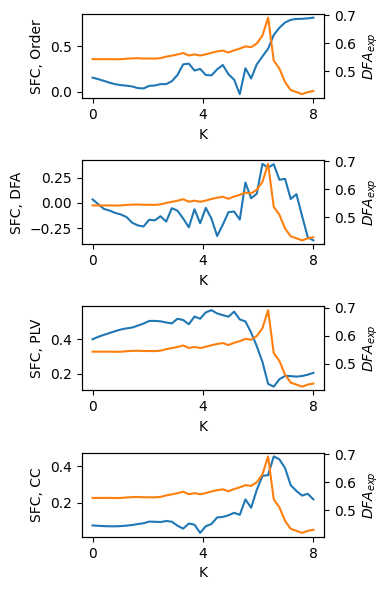

In [12]:
fig, axes = plt.subplots(figsize=(4,6), nrows=4)
axes_twins = [ax.twinx() for ax in axes]

sfc_corr_arr_list = [sc_vs_order_uniform, sc_vs_dfa_uniform, sc_vs_ps_uniform, sc_vs_cc_uniform]

for ax, ax_twin, obs_name, sfc_corr_arr in zip(axes, axes_twins, ['Order', 'DFA', 'PLV', 'CC'], sfc_corr_arr_list ):
    ax.plot(k_values, sfc_corr_arr, color='C0')
    ax_twin.plot(k_values, dfa_as_k.mean(axis=-1), color='C1')

    ax.set_xlabel('K', fontsize=10)
    ax.set_ylabel(f'SFC, {obs_name}', fontsize=10)
    ax_twin.set_ylabel(r'$DFA_{exp}$', fontsize=10)
    ax.set_xticks([0, 4, 8])

fig.tight_layout()

This behaviour is preserved across different connectomes such as power-law scaled one where both phase transition and emergence of LRTCs and CC during alongside with SFC is preserved.

In [13]:
connectome_powerlaw = generate_random_sc('pl_scaled')

In [14]:
k_values = np.linspace(0, 8, 40)

order_as_k_powerlaw = np.zeros((len(k_values), n_nodes))
dfa_as_k_powerlaw = np.zeros((len(k_values), n_nodes))
plv_as_k_powerlaw = np.zeros((len(k_values), n_nodes, n_nodes))
cc_as_k_powerlaw = np.zeros((len(k_values), n_nodes, n_nodes))

for k_idx, k in enumerate(k_values):
    model = KuramotoFast(n_oscillators, sfreq, k_list=[k]*n_nodes, weight_matrix=connectome_powerlaw*L, 
                     node_frequencies=node_frequencies, scale=frequency_scale, use_cuda=True)

    data_sim = model.simulate(sim_time)
    data_sim = data_sim[..., sfreq*20:]

    data_envelope = np.abs(data_sim)

    order_as_k_powerlaw[k_idx] = data_envelope.mean(axis=-1)
    dfa_as_k_powerlaw[k_idx] = dfa(data_envelope, window_lengths=dfa_win_lengths)[2]
    
    plv_as_k_powerlaw[k_idx] = np.abs(cplv(data_sim))
    cc_as_k_powerlaw[k_idx] = np.corrcoef(data_envelope)

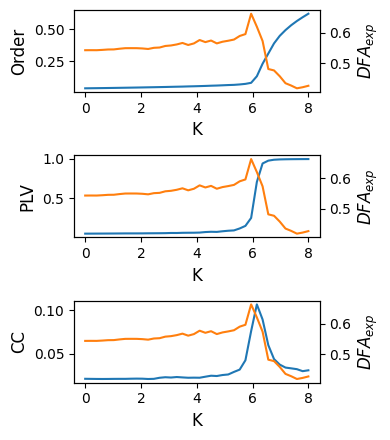

In [15]:
fig, axes = plt.subplots(figsize=(4,4.5), nrows=3)
axes_twins = [ax.twinx() for ax in axes]

observables_list = [order_as_k_powerlaw, plv_as_k_powerlaw.mean(axis=-1), cc_as_k_powerlaw.mean(axis=-1)]

for ax, ax_twin, observable_name, (observable_arr, observable_arr_twin) in zip(axes, axes_twins, ['Order', 'PLV', 'CC'],
                                                                               zip(observables_list, [dfa_as_k_powerlaw]*3)):
    
    ax.plot(k_values, observable_arr.mean(axis=-1), color='C0')
    ax_twin.plot(k_values, observable_arr_twin.mean(axis=-1), color='C1')

    ax.set_xlabel('K', fontsize=12)
    ax.set_ylabel(observable_name, fontsize=12)
    ax_twin.set_ylabel(r'$DFA_{exp}$', fontsize=12)

fig.tight_layout()